# P1

## a 

In [ ]:
# import data 
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.base import ClassifierMixin, BaseEstimator

In [ ]:
X, Y = load_digits(return_X_y = True)
Y = np.where(Y<5, -1, 1)

In [ ]:
X.shape 

(1797, 64)

In [ ]:
np.unique(Y)

array([-1,  1])

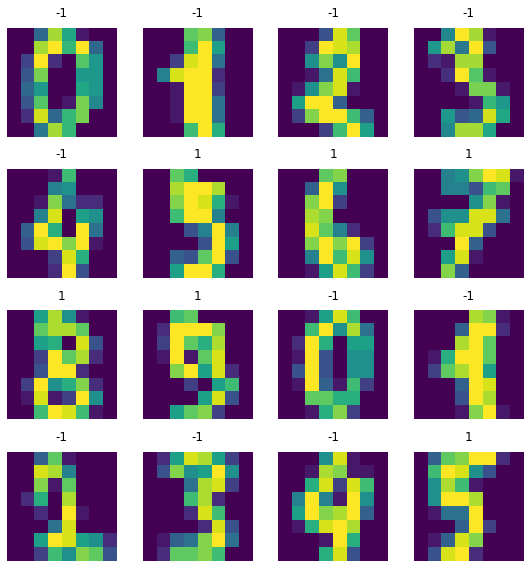

In [ ]:

fig, axs = plt.subplots(4 ,4 )
axs = axs.flatten() 
for ind,ax in enumerate(axs): 
  ax.matshow(X[ind].reshape(8,8))
  ax.set_title(f'{Y[ind]}')
  ax.set_axis_off()

fig.set_size_inches(8,8)
fig.set_tight_layout('pad')

In [ ]:
## Implement Adaboost 

In [ ]:
from functools import partial

In [ ]:
def decision_stumps(X, Y, D): 
  num_data, num_feature  = X.shape 
  min_obj = float('inf') 
  threshold, feature = None, None

  for fea in range(num_feature):
    data = X[:, fea].copy()
    sort_ind = np.argsort(data)

    sort_x = data[sort_ind]
    sort_x = np.r_[sort_x, sort_x[-1] + 1 ]

    sort_y = Y[sort_ind]
    sort_d = D[sort_ind]

    obj  = sort_d[sort_y == 1].sum() 

    if obj < min_obj: 
      min_obj = obj 
      threshold = sort_x[0]-1 
      feature = fea 

    for ind in range(num_data): 
      obj = obj - sort_y[ind]* sort_d[ind]

      if obj < min_obj and sort_x[ind] != sort_x[ind + 1]:
        min_obj = obj 
        threshold = 0.5 *(sort_x[ind] + sort_x[ind+1])
        feature = fea 

  def predictor(X, fea, threshold):

    predicts = np.ones(X.shape[0])

    predicts[X[:,fea] < threshold] = 1

    predicts[X[:,fea] > threshold] = -1

    return predicts 

  return partial(predictor, fea=feature, threshold=threshold)



In [ ]:
class AdaBoost(ClassifierMixin, BaseEstimator):
  def __init__(self, weak_learner, number_round):
    self.weak_learner = weak_learner 
    self.number_round = number_round 
    self.learners = []

  def fit(self, X, Y): 
    numbers_data = Y.shape[0] 
    d =  np.ones_like(Y)/numbers_data

    for round in range(self.number_round): 
      h = self.weak_learner(X, Y, d)

      error = d[Y != h(X)].sum()
      
      w = 0.5*(np.log(1/error -1))

      self.learners.append((h,w))

      # print(f'error: {error}\t w:{w}')

      temp = d * np.exp(- w * Y * h(X))
      
      d = temp/np.sum(temp)   

      # print(f'Round: {round} \t Acc: {accuracy_score(Y, self.predict(X))}')

  def predict(self, X): 

    result = np.zeros(X.shape[0])

    for learner,w in self.learners: 
      result += w * learner(X)  

    return np.where(result > 0, 1, -1)


In [ ]:
ada = AdaBoost(decision_stumps, 50)

In [ ]:
cross_val_score(ada, X, Y, cv=5)

array([0.80277778, 0.79722222, 0.78830084, 0.78830084, 0.79108635])

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dc = DecisionTreeClassifier(max_depth=1)

In [ ]:
skada = AdaBoostClassifier(dc)

In [ ]:
cross_val_score(skada, X, Y, cv=5)

array([0.83333333, 0.86666667, 0.91086351, 0.88857939, 0.8551532 ])

# P2 

In [ ]:
from sklearn.base import ClassifierMixin, BaseEstimator, RegressorMixin

## b(iii)

In [ ]:
class Boost_logistic_loss(ClassifierMixin, BaseEstimator):
  def __init__(self, weak_learner, number_round=100, step_size=1e-1):
    self.weak_learner = weak_learner 
    self.number_round = number_round 
    self.step_size = step_size 
    self.learners = [(lambda x : np.zeros(x.shape[0]) ,self.step_size),]
  
  def __call__(self, X):
    result = np.zeros(X.shape[0])

    for learner, w in self.learners: 
      result += w * learner(X)

    return result 

  def fit(self, X, Y): 

    numbers_data = Y.shape[0] 

    for round in range(self.number_round): 

      z =  np.sum(1/(1+ np.exp(Y * self(X))))
      d =  (1/(1+ np.exp(Y * self(X))))/z 
      h = self.weak_learner(X, Y, d)

      # error = d[Y != h(X)].sum()
      
      # w = 0.5*(np.log(1/error -1))

      if self.step_size: 
        step = self.step_size
      else:
        error = d[Y != h(X)].sum()
        step = 0.5*(np.log(1/error -1))

      self.learners.append((h, step))

      # print(f'error: {error}\t w:{w}')
      # if verbose:
      # print(f'Round: {round} \t Acc: {accuracy_score(Y, self.predict(X))}')

  def predict(self, X): 

    result = self(X)

    # for learner,w in self.learners: 
      # result += w * learner(X)  

    return np.where(result > 0, 1, -1)


In [ ]:
for lr in np.linspace(0, 10, 20):
  bl = Boost_logistic_loss(decision_stumps, step_size=lr )
  bl.fit(X,Y)
  print(f'lr: {lr}\t acc: {accuracy_score(Y, bl.predict(X))}')


lr: 0.0	 acc: 0.8269337785197551
lr: 0.5263157894736842	 acc: 0.8341680578742349
lr: 1.0526315789473684	 acc: 0.8447412353923205
lr: 1.5789473684210527	 acc: 0.8102392877017252
lr: 2.1052631578947367	 acc: 0.8196994991652755
lr: 2.631578947368421	 acc: 0.803561491374513
lr: 3.1578947368421053	 acc: 0.798553144129104
lr: 3.6842105263157894	 acc: 0.7890929326655537
lr: 4.2105263157894735	 acc: 0.7946577629382304
lr: 4.7368421052631575	 acc: 0.7913188647746243
lr: 5.263157894736842	 acc: 0.7996661101836394
lr: 5.789473684210526	 acc: 0.800222593210907
lr: 6.315789473684211	 acc: 0.800222593210907
lr: 6.842105263157895	 acc: 0.7946577629382304
lr: 7.368421052631579	 acc: 0.7913188647746243
lr: 7.894736842105263	 acc: 0.800222593210907
lr: 8.421052631578947	 acc: 0.7946577629382304
lr: 8.947368421052632	 acc: 0.7946577629382304
lr: 9.473684210526315	 acc: 0.7918753478018921
lr: 10.0	 acc: 0.7918753478018921


In [ ]:
bl = Boost_logistic_loss(decision_stumps, step_size=1)

In [ ]:
cross_val_score(bl, X, Y, cv=5)

array([0.79444444, 0.73888889, 0.80501393, 0.77158774, 0.77715877])

## b(iv)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn import metrics

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
def display_scores(scores):
  print(f'scores: {scores}')
  print(f'Mean: {scores.mean()}')
  print(f'Std: {scores.std()}')

In [ ]:
X2, Y2 = load_boston(return_X_y = True)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.1, random_state=42)

In [ ]:
for i in range(10):
  dtr = DecisionTreeRegressor(max_leaf_nodes=5)
  dtr.fit(X2_train, Y2_train)
  print(f'Error :{metrics.mean_squared_error(Y2_test, dtr.predict(X2_test))}')

Error :23.536607739512178
Error :23.536607739512174
Error :23.536607739512178
Error :23.53660773951218
Error :23.53660773951217
Error :23.536607739512196
Error :23.536607739512196
Error :23.536607739512203
Error :23.536607739512203
Error :23.53660773951217


In [ ]:
class Boost_CART(RegressorMixin, BaseEstimator):
  def __init__(self, weak_learner, number_round=100):
    self.weak_learner = weak_learner 
    self.number_round = number_round 
    self.learners = []

  def __call__(self, X):
    result = np.zeros(X.shape[0])

    if not self.learners: 
      return result 
    else:
      for learner in self.learners: 
        result += learner.predict(X)
    return result 

  def fit(self, X, Y): 

    for round in range(self.number_round): 
      residual = Y - self(X)
      # print(residual.mean())
      weak_learner = self.weak_learner() 
      weak_learner.fit(X, residual)
      self.learners.append(weak_learner)

  def predict(self, X): 

    return self(X)


In [ ]:
for i in range(5):
  bc = Boost_CART(partial(DecisionTreeRegressor, max_leaf_nodes=5), 100)
  bc.fit(X2_train, Y2_train)
  print(f'Error: {metrics.mean_squared_error(Y2_test, bc.predict(X2_test))}')

Error: 4.727736401477419
Error: 4.8109653844403395
Error: 4.727736401477413
Error: 4.811960883946464
Error: 4.72773640147742


# p3

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn import metrics

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import ClassifierMixin, BaseEstimator, RegressorMixin

In [ ]:
def display_scores(scores):
  print(f'scores: {scores}')
  print(f'Mean: {scores.mean()}')
  print(f'Std: {scores.std()}')

In [ ]:
X2, Y2 = load_boston(return_X_y = True)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.1, random_state=42)

## a 

In [ ]:
class Bagging_CART(RegressorMixin, BaseEstimator): 
  def __init__(self, weak_learner, number_round=100 ):
    self.weak_learner = weak_learner 
    self.number_round = number_round 
    self.learners = []

  def __call__(self, X):
    result = np.zeros(X.shape[0])

    if not self.learners: 
      return result 
    else:
      for learner in self.learners: 
        result += learner.predict(X)

    return result/self.number_round

  def fit(self, X, Y): 
    

    # weak_learner = self.weak_learner() 
    # weak_learner.fit(X, Y)
    # self.learners.append(weak_learner)

    for round in range(self.number_round): 
      ind = np.random.choice(X.shape[0],X.shape[0], )
      BX = X[ind,:]
      BY = Y[ind]

      weak_learner = self.weak_learner() 
      weak_learner.fit(BX,BY)

      self.learners.append(weak_learner)

  def predict(self, X): 

    return self(X)




In [ ]:
# reduce variance 
for i in range(5):
  bg = Bagging_CART(partial(DecisionTreeRegressor), 100)
  bg.fit(X2_train, Y2_train)
  print(f'Error: {metrics.mean_squared_error(Y2_test, bg.predict(X2_test))}')

Error: 8.718871274509807
Error: 9.424940392156875
Error: 8.065484078431378
Error: 11.055133392156877
Error: 9.481172411764707


In [ ]:
# Larger Baise 
for i in range(5):
  d= DecisionTreeRegressor()
  d.fit(X2_train, Y2_train)
  print(f'Error: {metrics.mean_squared_error(Y2_test, d.predict(X2_test))}')

Error: 33.34058823529412
Error: 11.772745098039218
Error: 11.821568627450983
Error: 34.48862745098039
Error: 33.73274509803922


## b 

In [ ]:
class MyRandomForest(RegressorMixin, BaseEstimator):
  def __init__(self,  weak_learner, number_round=100,):
    self.weak_learner = weak_learner 
    self.number_round = number_round 
    self.learners = []
    self.oob = {}
    self.oob_score= 0
  def __call__(self, X):
    result = np.zeros(X.shape[0])

    if not self.learners: 
      return result 
    else:
      for learner in self.learners: 
        result += learner.predict(X)

    return result/self.number_round

  def fit(self, X, Y): 
    
    for round in range(self.number_round): 
      self.oob = set(list(range(X.shape[0])))
      ind = np.random.choice(X.shape[0],X.shape[0], )

      self.oob = self.oob - set(ind)

      BX = X[ind,:]
      BY = Y[ind]

      weak_learner = self.weak_learner() 
      weak_learner.fit(BX,BY)

      self.learners.append(weak_learner)

      oobx, ooby = X[list(self.oob),:], Y[list(self.oob)]
      self.oob_score += metrics.mean_squared_error(ooby, self.predict(oobx))
    # print(f"OOB Error:{self.oob_score/self.number_round}")

  def predict(self, X): 

    return self(X)



In [ ]:
#max feature/m = p/3 
#

for i in range(5):
  mrf = MyRandomForest(partial(DecisionTreeRegressor, max_features= max(X2.shape[1]//3,5)), 100)
  mrf.fit(X2_train, Y2_train)
  print(f'Error: {metrics.mean_squared_error(Y2_test, mrf.predict(X2_test))}')

Error: 5.244079843137252
Error: 6.062448039215684
Error: 6.783053803921562
Error: 6.428040078431373
Error: 4.72338462745098


## c 

In [ ]:
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_validate

### Cross Validation

In [ ]:
trees = 100
e1s,e2s,e3s = [],[],[] 

for num_tree in tqdm(range(trees)):
  bc = Boost_CART(partial(DecisionTreeRegressor, max_leaf_nodes=5), num_tree)
  s1  = cross_validate(bc ,X2, Y2, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1)
  e1s.append((-s1['test_score']).mean())

  # reduce variance 
  bg = Bagging_CART(partial(DecisionTreeRegressor), num_tree)
  s2  = cross_validate(bg ,X2, Y2, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1)
  e2s.append((-s2['test_score']).mean())

  mrf = MyRandomForest(partial(DecisionTreeRegressor, max_features= max(X2.shape[1]//3,5)), num_tree)
  s3  = cross_validate(mrf ,X2, Y2, scoring='neg_mean_squared_error', cv=10, return_train_score=True, n_jobs=-1)
  e3s.append((-s3['test_score']).mean())



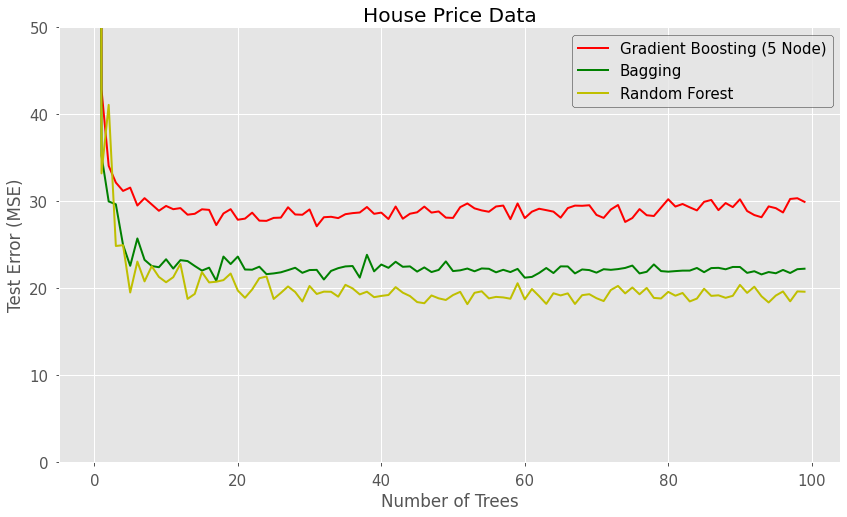

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots() 
x = range(trees)
 

ax.plot(x, e1s, color='r', linewidth=2, label='Gradient Boosting (5 Node)')
ax.plot(x, e2s, color='g', linewidth=2, label='Bagging')
ax.plot(x, e3s, color='y', linewidth=2,label='Random Forest')

ax.legend(fontsize=15,edgecolor='k',fancybox=True)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylim(0, 50)
ax.set_title(f'House Price Data')
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Error (MSE)')
fig.set_size_inches(14,8)

plt.savefig(f'CV.png',  
			format='png',  
			bbox_inches='tight',  
			dpi=300  
			)

### Train and Test set 

In [ ]:
trees = 100
e1s,e2s,e3s = [],[],[] 

for num_tree in tqdm(range(trees)):
  bc = Boost_CART(partial(DecisionTreeRegressor, max_leaf_nodes=5), num_tree)
  bc.fit(X2_train, Y2_train)
  e1 = metrics.mean_squared_error(Y2_test, bc.predict(X2_test))
  e1s.append(e1)

  # reduce variance 
  bg = Bagging_CART(partial(DecisionTreeRegressor), num_tree)
  bg.fit(X2_train, Y2_train)
  e2 = metrics.mean_squared_error(Y2_test, bg.predict(X2_test))
  e2s.append(e2)

  mrf = MyRandomForest(partial(DecisionTreeRegressor, max_features= max(X2.shape[1]//3,5)), num_tree)
  mrf.fit(X2_train, Y2_train)
  e3 = metrics.mean_squared_error(Y2_test, mrf.predict(X2_test))
  e3s.append(e3)



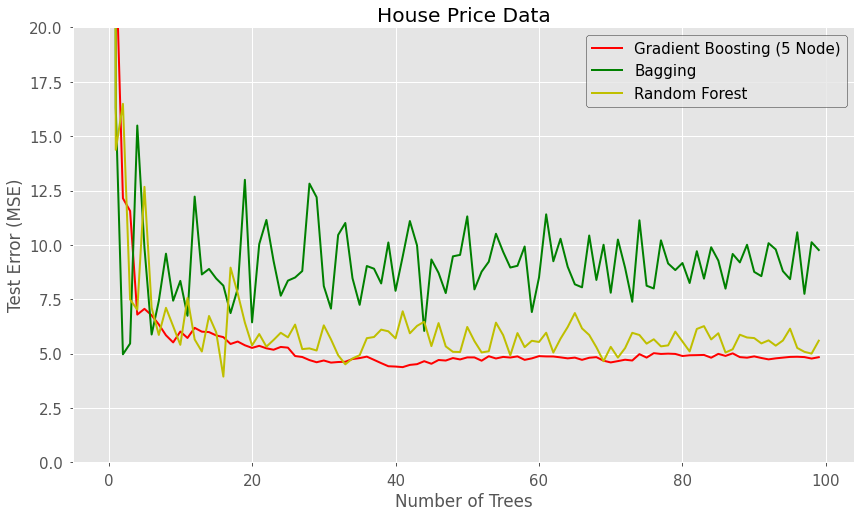

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots() 
x = range(trees)
 

ax.plot(x, e1s, color='r', linewidth=2, label='Gradient Boosting (5 Node)')
ax.plot(x, e2s, color='g', linewidth=2, label='Bagging')
ax.plot(x, e3s, color='y', linewidth=2,label='Random Forest')

ax.legend(fontsize=15,edgecolor='k',fancybox=True)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.set_ylim(0, 20)
ax.set_title(f'House Price Data')
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Test Error (MSE)')
fig.set_size_inches(14,8)
plt.savefig(f'NCV.png',  
			format='png',  
			bbox_inches='tight',  
			dpi=300  
			)